# Prepare Workspace 

## Load Packages

In [1]:
library(cluster)
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Plotting Parameters


In [63]:
options(repr.plot.width=5, repr.plot.height=4)

## Clean Data

In [9]:
#### READ IN DATA ####
df = as_tibble(read_csv("data/questionnaires.csv"), stringsAsFactors = FALSE)

Parsed with column specification:
cols(
  .default = col_character(),
  `Please indicate your age in years:` = col_double(),
  `Please indicate how much you currently weigh (in lbs)` = col_double(),
  `Please indicate your height (feet, inches)` = col_double(),
  `How long have you been living in Canada?` = col_double(),
  `What time did you eat the food you indicated in the last question?` = col_time(format = ""),
  `How difficult was it to make choices during trials when you were asked to RESPOND NATURALLY?` = col_double(),
  `How much did you think about the health of the foods when choosing NATURALLY?` = col_double(),
  `How much did you try to decrease your desire for the foods when choosing NATURALLY?` = col_double(),
  `How difficult was it to make choices during trials when you were asked to DECREASE YOUR DESIRE?` = col_double(),
  `How much did you think about the health of the foods when trying to DECREASE DESIRE?` = col_double(),
  `How much did you try to reduce your cravin

In [15]:
# Select fMRI study subjects
fmri_sub <- grepl("FRMRI*", df[, 2][[1]])
df = df[fmri_sub, ]
df = data.table::as.data.table(df)

# Rename demo cols
names(df)[1:13] = c("demo_time",
                    "demo_id",
                    "demo_female",
                    "demo_ethnicity",
                    "demo_age",
                    "demo_weight",
                    "demo_height",
                    "demo_yrs_canada",
                    "demo_diet",
                    "demo_diet_detail",
                    "demo_familiar",
                    "demo_previous_food",
                    "demo_previous_food_time")

# Recode female
df[demo_female == "Female", demo_female := "1"]
df[demo_female == "Male", demo_female := "0"]

# Rename conditional effects cols
names(df)[14:24] = c("ce_1_diff_nat",
                    "ce_2_focus_h_nat",
                    "ce_3_focus_dd_nat",
                    "ce_4_diff_dd",
                    "ce_5_focus_h_dd",
                    "ce_6_focus_reduce_craving_dd",
                    "ce_7_success_control_response_dd",
                    "ce_8_diff_h",
                    "ce_9_focus_h_h",
                    "ce_10_focus_reduce_craving_h",
                    "ce_11_success_control_response_h")

# Rename strategy cols
names(df)[25:40] = c("s_1_think_unhealthy",
                    "s_2_xthink_hungry",
                    "s_3_change_foodthoughts",
                    "s_4_xlook_pics",
                    "s_5_think_healthy",
                    "s_6_xchange_want_changed_choice",
                    "s_7_try_dd",
                    "s_8_try_xthink_tasty",
                    "s_9_think_unhealthy",
                    "s_10_xthink_hungry",
                    "s_11_change_food_thoughts",
                    "s_12_xlook_pics",
                    "s_13_think_healthy",
                    "s_14_xchange_want_changed_choice",
                    "s_15_try_dd",
                    "s_16_try_xthink_tasty")


# Clean up DF
df <- df %>%
  mutate(
    demo_id = readr::parse_number(demo_id)
  )
remove(fmri_sub)

# List of good subjects
good_subjects = c(101:104, 106:112, 114, 116, 118:121, 123:126, 129:137, 139:140, 142:148, 150, 152:158, 162:164)
# Remove excluded subjects
df_good = df[df$demo_id %in% good_subjects,]


#### CLUSTERING ####

# Remove extra questionnaire cols
df_cluster = df_good[,1:40]

# Export CSV
write.csv(df_cluster, "data/cluster_cleaned.csv", row.names = FALSE)

## Read Data

In [65]:
dataset = read_csv("data/cluster_cleaned.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  demo_time = col_character(),
  demo_ethnicity = col_character(),
  demo_diet = col_character(),
  demo_diet_detail = col_character(),
  demo_familiar = col_character(),
  demo_previous_food = col_character(),
  demo_previous_food_time = col_time(format = "")
)
See spec(...) for full column specifications.


In [66]:
head(dataset,3)

demo_time,demo_id,demo_female,demo_ethnicity,demo_age,demo_weight,demo_height,demo_yrs_canada,demo_diet,demo_diet_detail,⋯,s_7_try_dd,s_8_try_xthink_tasty,s_9_think_unhealthy,s_10_xthink_hungry,s_11_change_food_thoughts,s_12_xlook_pics,s_13_think_healthy,s_14_xchange_want_changed_choice,s_15_try_dd,s_16_try_xthink_tasty
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6/27/2018 16:15:13,101,1,White/Caucasian,28,118,170.0,28,No,NA,⋯,7,9,8,7,5,1,8,6,8,7
6/28/2018 17:50:06,102,1,Asian/Asian Canadian,23,109,162.5,5,Yes,"low carb, 6 months",⋯,2,8,8,4,4,1,4,5,3,4
6/29/2018 15:19:16,103,1,Asian/Asian Canadian,20,110,157.5,3,Yes,Juice cleanse -- 1 week,⋯,8,8,8,8,8,3,8,8,9,8


# Cluster Analysis

## Data Prep

In [67]:
# string of strateguy variables
strat_vars = dataset %>% select(starts_with("s_")) %>% names()

In [68]:
# Creating a dataframe of only the quantitative measures from wine.data
analysis_data = dataset %>%
  select(c(demo_id, starts_with("s_"))) %>%
  mutate_at(.vars=strat_vars, scale) %>% # Standardize the data
  column_to_rownames("demo_id") # Converts the id column to rownames so it won't interfere with analyses but will label cases

In [69]:
head(analysis_data,3)

,s_1_think_unhealthy,s_2_xthink_hungry,s_3_change_foodthoughts,s_4_xlook_pics,s_5_think_healthy,s_6_xchange_want_changed_choice,s_7_try_dd,s_8_try_xthink_tasty,s_9_think_unhealthy,s_10_xthink_hungry,s_11_change_food_thoughts,s_12_xlook_pics,s_13_think_healthy,s_14_xchange_want_changed_choice,s_15_try_dd,s_16_try_xthink_tasty
,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
101,0.3304269,0.78528768,0.7192052,0.7354075,-0.5604485,0.03897922,0.6267867,0.35868479,0.4296067,0.4124671,-0.3715007,-0.5774705,0.7337212,0.2990363,0.4603598,0.2699392
102,-1.8774254,0.05816946,1.1100776,-1.1263836,-0.5604485,0.42877146,-1.1743246,-0.03985387,0.4296067,-0.7124432,-0.7505831,-0.5774705,-0.5882990,-0.1281584,-1.6709357,-0.9325173
103,1.0663776,-1.03250787,1.5009501,0.2699597,0.0000000,0.81856369,0.9870090,-0.03985387,0.4296067,0.7874372,0.7657464,0.2474874,0.7337212,1.1534258,0.8866189,0.6707580


## Create Distance Matrix

In [70]:
#Create and View a Distance Matrix using a Squared Euclidean Distance measure
distance_matrix = analysis_data %>%
  dist(method="euclidean") %>% # This line creates the distance matrix
  .**2 # This squares every value in the distance matrix

In [71]:
# Look at your distance matrix
distance_matrix %>%
  print

          101       102       103       104       106       107       108
102 21.904814                                                            
103  9.071041 34.826737                                                  
104 13.768992 15.912929 16.357794                                        
106  6.469040 14.407791 16.882198 10.873825                              
107 27.085256 43.117243 36.475365 23.954147 33.730580                    
108 10.733809 31.137288 29.181743 26.098267 18.320486 44.925576          
109 34.712103 38.684922 39.075153 23.396130 22.511550 43.526175 54.961785
110 17.260702 13.576365 27.883364 15.520259 15.987289 41.498418 17.707912
111 29.305823 50.744593 25.478974 33.655225 36.578421 52.969255 40.401163
112  8.109060 19.345979 15.951012  8.901858 10.424670 24.360233 14.398805
114 23.150467 30.771021 32.451394 15.764465 27.113205 28.592945 34.326894
116 55.338401 25.566210 66.489528 31.564997 43.822389 60.935345 61.621753
118  7.942677 44.429989 10.262278 26.1

## Hierarchical Cluster Analysis

In [72]:
#Conduct an agglomerative hierarchical cluster analysis using Ward's Method
hierarchical_cluster = distance_matrix %>%
  hclust(method="ward.D")

## Evaluate Agglomeration Tables and Plots

In [73]:
#Print a table similar to an Agglomeration Schedule
agglomeration_schedule = data.frame(step     = 1:length(hierarchical_cluster$height), # Make step an explicit column
                                    cluster  = hierarchical_cluster$merge, 
                                    distance = hierarchical_cluster$height) %>% # Create a data frame from values in the hierarchical cluster results
  round(2) # Make the distances a bit more human-readable (at least easier to read, for me)

head(agglomeration_schedule)

,step,cluster.1,cluster.2,distance
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,-1,-29,3.82
2,2,-4,-32,4.86
3,3,-17,-39,5.01
4,4,-3,-33,5.18
5,5,-13,-18,5.92
6,6,-20,-41,6.65


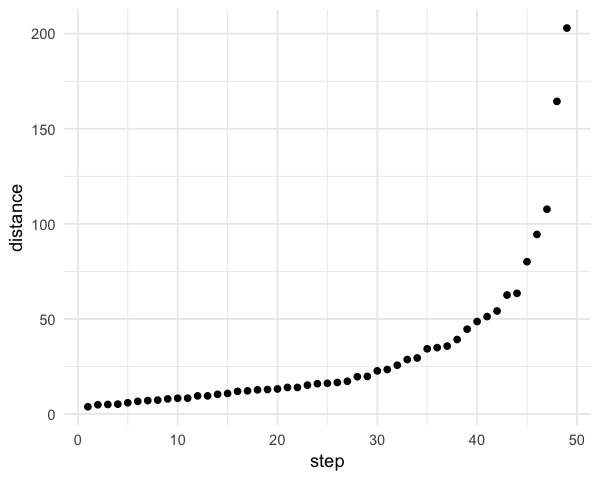

In [74]:
#Print a reversed Scree plot
agglomeration_schedule %>%
    ggplot(aes(x = step, y = distance)) + 
    geom_point() +
    theme_minimal()

## Save Cluster Membership

In [157]:
# Note, I have decided to use 5 clusters
dataset = dataset %>%
  cbind(clusters = cutree(hierarchical_cluster, k=5))

## Visualization

In [158]:
options(repr.plot.width=8, repr.plot.height=5)

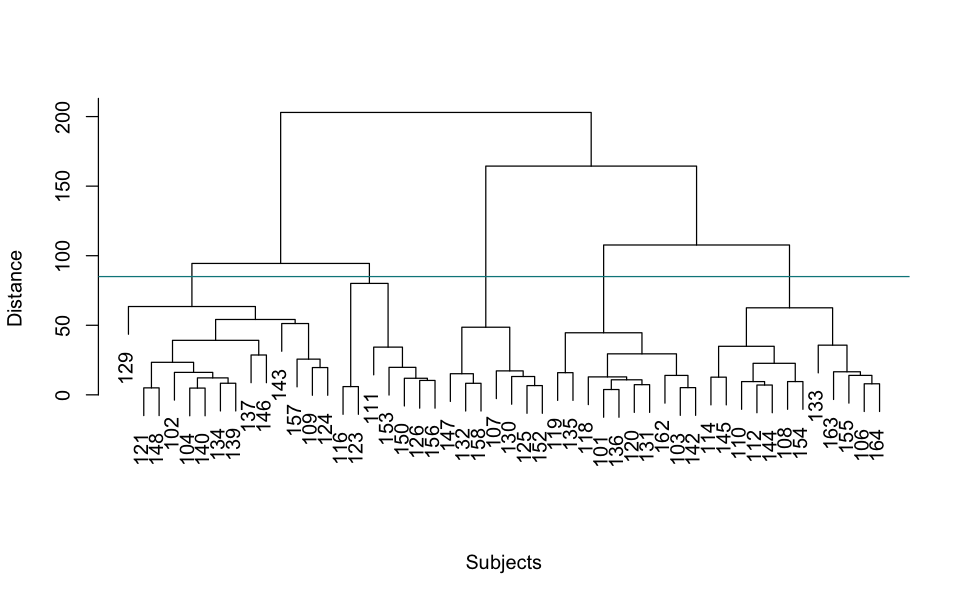

In [159]:
hierarchical_cluster %>%
    plot(xlab="Subjects", main = "", sub = "", ylab = "Distance")
    abline(h=85, col="turquoise4")

## K-Means Cluster Analysis

In [84]:
strat_vars

[1] "s_1_think_unhealthy"              "s_2_xthink_hungry"               
 [3] "s_3_change_foodthoughts"          "s_4_xlook_pics"                  
 [5] "s_5_think_healthy"                "s_6_xchange_want_changed_choice" 
 [7] "s_7_try_dd"                       "s_8_try_xthink_tasty"            
 [9] "s_9_think_unhealthy"              "s_10_xthink_hungry"              
[11] "s_11_change_food_thoughts"        "s_12_xlook_pics"                 
[13] "s_13_think_healthy"               "s_14_xchange_want_changed_choice"
[15] "s_15_try_dd"                      "s_16_try_xthink_tasty"

In [126]:
## THIS DID NOT WORK, SO I USED THE VERSION BELOW
# First, use hierarchically derived clusters to export starting centres for K-Means
hierarchical_centres = dataset %>%
    group_by(clusters) %>%
    summarize(think_unhealthy_mean = mean(scale(s_1_think_unhealthy)),
              xthink_hungry_mean   = mean(scale(s_2_xthink_hungry)),
              change_foodthoughts_mean   = mean(scale(s_3_change_foodthoughts)),
              xlook_pics_mean = mean(scale(s_4_xlook_pics)),
              think_healthy_mean = mean(scale(s_5_think_healthy)),
              xchange_want_changed_choice_mean = mean(scale(s_6_xchange_want_changed_choice)),
              try_dd_mean = mean(scale(s_7_try_dd)),
              try_xthink_tasty_mean = mean(scale(s_8_try_xthink_tasty)),
              think_unhealthy_mean = mean(scale(s_9_think_unhealthy)),
              xthink_hungry_mean = mean(scale(s_10_xthink_hungry)),
              change_food_thoughts_mean = mean(scale(s_11_change_food_thoughts)),
              xlook_pics_mean = mean(scale(s_12_xlook_pics)),
              think_healthy_mean = mean(scale(s_13_think_healthy)),
              xchange_want_changed_choice_mean = mean(scale(s_14_xchange_want_changed_choice)),
              try_dd_mean = mean(scale(s_15_try_dd)),
              try_xthink_tasty_mean = mean(scale(s_16_try_xthink_tasty))
             ) %>%
    select(think_unhealthy_mean, 
           xthink_hungry_mean, 
           change_foodthoughts_mean,
           xlook_pics_mean,
           think_healthy_mean,
           xchange_want_changed_choice_mean,
           try_dd_mean,
           try_xthink_tasty_mean,
           think_unhealthy_mean,
           xthink_hungry_mean,
           change_food_thoughts_mean,
           xlook_pics_mean,
           think_healthy_mean,
           xchange_want_changed_choice_mean,
           try_dd_mean,
           try_xthink_tasty_mean
          )

In [143]:
# First, use hierarchically derived clusters to export starting centres for K-Means

hierarchical_centres = dataset %>%
    group_by(clusters) %>%
    select(starts_with("s_")) %>%
    mutate_at(.vars=strat_vars, scale) %>% # Standardize the data
    summarise_all(list(mean = mean), na.rm=T) %>% # calculate means for each cluster for each column
    select(-clusters) # remove this column

Adding missing grouping variables: `clusters`


In [144]:
hierarchical_centres

s_1_think_unhealthy_mean,s_2_xthink_hungry_mean,s_3_change_foodthoughts_mean,s_4_xlook_pics_mean,s_5_think_healthy_mean,s_6_xchange_want_changed_choice_mean,s_7_try_dd_mean,s_8_try_xthink_tasty_mean,s_9_think_unhealthy_mean,s_10_xthink_hungry_mean,s_11_change_food_thoughts_mean,s_12_xlook_pics_mean,s_13_think_healthy_mean,s_14_xchange_want_changed_choice_mean,s_15_try_dd_mean,s_16_try_xthink_tasty_mean
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.053113e-16,-1.276648e-16,-1.111307e-17,-8.937268e-16,-4.998172e-17,-1.082576e-16,2.192799e-16,-4.440892e-16,-1.109681e-17,-5.884074e-16,-1.554258e-16,-1.110223e-16,-1.720934e-16,1.054522e-16,-7.769393e-17,-1.865686e-16
7.137148e-17,1.006759e-18,3.171291e-17,-2.061552e-16,1.903046e-16,1.982541e-18,1.781576e-17,-4.657423e-17,-1.288574e-16,-1.487061e-16,-1.472017e-16,5.151509e-17,-2.997045e-18,-1.387779e-16,2.280116e-16,-3.271967e-17
1.017682e-16,-1.480218e-16,1.249001e-16,7.123931e-16,2.775558e-17,-1.283695e-16,-9.250955e-17,4.579670e-16,-3.284139e-16,-1.616365e-17,-1.329955e-16,4.972422e-17,1.618172e-17,1.196959e-16,-2.775558e-17,-1.433857e-16
6.345680e-17,-2.220446e-16,9.121238e-17,-2.061804e-16,-1.348302e-16,-9.515423e-17,-8.723955e-17,1.570173e-15,1.823938e-16,8.088613e-16,-5.630572e-16,7.632783e-17,-1.308322e-16,-1.030825e-16,2.458351e-16,2.458428e-16
1.804112e-16,0.000000e+00,9.121044e-17,1.249001e-16,1.189660e-16,9.913480e-17,-9.513487e-17,7.139471e-17,0.000000e+00,-9.121044e-17,-1.219176e-16,-1.506576e-16,-3.768474e-17,8.326673e-17,-1.308361e-16,-1.506576e-16


In [152]:
# check dfs for NAs
print(sum(is.na(hierarchical_centres)))
print(sum(is.na(analysis_data)))

[1] 0
[1] 0


In [151]:
# replace nas with 0
analysis_data[is.na(analysis_data)] <- 0

In [153]:
# Next, use hierarchically derived cluster means as start values to k-means
kmeans_cluster = analysis_data %>%
  kmeans(hierarchical_centres, iter.max = 100, algorithm="MacQueen")

In [154]:
# Examine the descriptive stats for each cluster
kmeans_cluster$centers %>%
  print

  s_1_think_unhealthy s_2_xthink_hungry s_3_change_foodthoughts s_4_xlook_pics
1          -0.5669825       -0.36598284              -0.3231212     -0.8678015
2           0.1924361        0.60350812              -0.8931435      0.5026836
3           0.0442238        0.38133311               0.2849026      0.6319746
4           0.6458343       -0.07167308               0.8588025      0.3696985
5          -0.7734992       -0.66894876              -1.6260292      0.7354075
  s_5_think_healthy s_6_xchange_want_changed_choice  s_7_try_dd
1       -0.03113603                      -0.3291579 -0.47389239
2       -0.14011213                       0.9647358 -0.04863001
3       -0.06227206                      -1.0004667 -0.57395413
4        0.20016019                       0.4009292  0.90981851
5       -0.56044854                       1.5981482  1.34723125
  s_8_try_xthink_tasty s_9_think_unhealthy s_10_xthink_hungry
1           -0.6155208          -0.1792463        -0.62911652
2            0.209

In [163]:
#=== Example 9.8: K-Medoids Cluster Analysis ====
kmedoids_cluster = analysis_data %>%
  pam(5) # specify number of clusters

# See the cluster assignments
analysis_data %>%
  cbind(kmedoids_cluster$clustering)
# See the medoids
## Note, they are ordered by cluster number (i.e., row 1 == Cluster 1, ...))
analysis_data %>%
  rownames_to_column("Varietal") %>%
  slice(kmedoids_cluster$id.med)

,s_1_think_unhealthy,s_2_xthink_hungry,s_3_change_foodthoughts,s_4_xlook_pics,s_5_think_healthy,s_6_xchange_want_changed_choice,s_7_try_dd,s_8_try_xthink_tasty,s_9_think_unhealthy,s_10_xthink_hungry,s_11_change_food_thoughts,s_12_xlook_pics,s_13_think_healthy,s_14_xchange_want_changed_choice,s_15_try_dd,s_16_try_xthink_tasty,kmedoids_cluster$clustering
,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<int>
101,0.33042686,0.78528768,0.71920524,0.7354075,-0.5604485,0.03897922,0.62678673,0.35868479,0.429606711,0.41246712,-0.371500722,-0.5774705,0.73372119,0.2990363,0.46035984,0.2699392,1
102,-1.87742535,0.05816946,1.11007765,-1.1263836,-0.5604485,0.42877146,-1.17432457,-0.03985387,0.429606711,-0.71244321,-0.750583092,-0.5774705,-0.58829897,-0.1281584,-1.67093570,-0.9325173,2
103,1.06637760,-1.03250787,1.50095006,0.2699597,0.0000000,0.81856369,0.98700899,-0.03985387,0.429606711,0.78743723,0.765746387,0.2474874,0.73372119,1.1534258,0.88661894,0.6707580,1
104,-0.40552388,-1.39606698,-0.45341200,-0.6609358,-0.5604485,0.42877146,0.26656447,-0.43839253,-0.447141679,-1.08741332,0.386664017,-0.5774705,0.40321615,-0.1281584,0.03410073,-0.1308796,3
106,-0.77349925,0.42172857,0.71920524,0.2699597,0.0000000,-0.35081301,-0.45388005,0.35868479,-0.008767484,-0.71244321,-0.371500722,-0.5774705,0.73372119,0.7262311,0.88661894,-0.9325173,1
107,-0.03754851,1.14884679,-1.23515682,-0.6609358,-0.5604485,1.20835592,0.98700899,0.75722345,-2.639012655,0.41246712,1.144828756,-0.5774705,-1.24930905,-1.4097426,0.88661894,1.0715769,4
108,1.43435297,1.87596501,-0.06253959,0.7354075,-0.5604485,-0.35081301,0.26656447,0.75722345,1.306355102,-1.46238342,-1.129665462,-0.5774705,1.39473127,-0.1281584,-0.81841748,0.6707580,1
109,-0.03754851,-1.03250787,-0.84428441,0.7354075,-0.5604485,-1.90998194,-1.53454683,-0.83693119,-1.323890070,-0.71244321,1.523911126,-0.1649916,-1.57981409,1.1534258,1.31287805,-1.7341550,2
110,-0.03754851,0.78528768,-0.06253959,-0.1954881,0.0000000,0.81856369,0.26656447,-0.03985387,0.867980907,-1.08741332,0.386664017,0.2474874,0.73372119,-0.1281584,-2.09719480,-1.7341550,3


Varietal,s_1_think_unhealthy,s_2_xthink_hungry,s_3_change_foodthoughts,s_4_xlook_pics,s_5_think_healthy,s_6_xchange_want_changed_choice,s_7_try_dd,s_8_try_xthink_tasty,s_9_think_unhealthy,s_10_xthink_hungry,s_11_change_food_thoughts,s_12_xlook_pics,s_13_think_healthy,s_14_xchange_want_changed_choice,s_15_try_dd,s_16_try_xthink_tasty
<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
101,0.3304269,0.7852877,0.7192052,0.7354075,-0.5604485,0.03897922,0.62678673,0.35868479,0.4296067,0.41246712,-0.3715007,-0.5774705,0.7337212,0.2990363,0.46035984,0.2699392
139,-0.7734992,-0.3053897,-0.4534120,-0.1954881,0.0000000,-0.74060524,-0.81410231,-0.03985387,0.4296067,0.03749701,-1.1296655,0.6599663,-0.5882990,-0.1281584,0.46035984,-0.1308796
104,-0.4055239,-1.3960670,-0.4534120,-0.6609358,-0.5604485,0.42877146,0.26656447,-0.43839253,-0.4471417,-1.08741332,0.3866640,-0.5774705,0.4032161,-0.1281584,0.03410073,-0.1308796
158,1.0663776,1.5124059,-0.8442844,0.2699597,0.5604485,0.42877146,1.34723125,0.35868479,-0.4471417,1.16240734,0.3866640,0.2474874,-0.2577939,-0.9825479,0.46035984,1.0715769
123,-0.4055239,-0.6689488,-0.4534120,-3.4536223,0.0000000,-0.74060524,-0.09365779,-0.83693119,-0.8855159,0.78743723,-1.8878302,-0.5774705,-0.9188040,-0.1281584,-1.24467659,-1.7341550


## Evaluating Cluster Structure With Silhouette Statistics

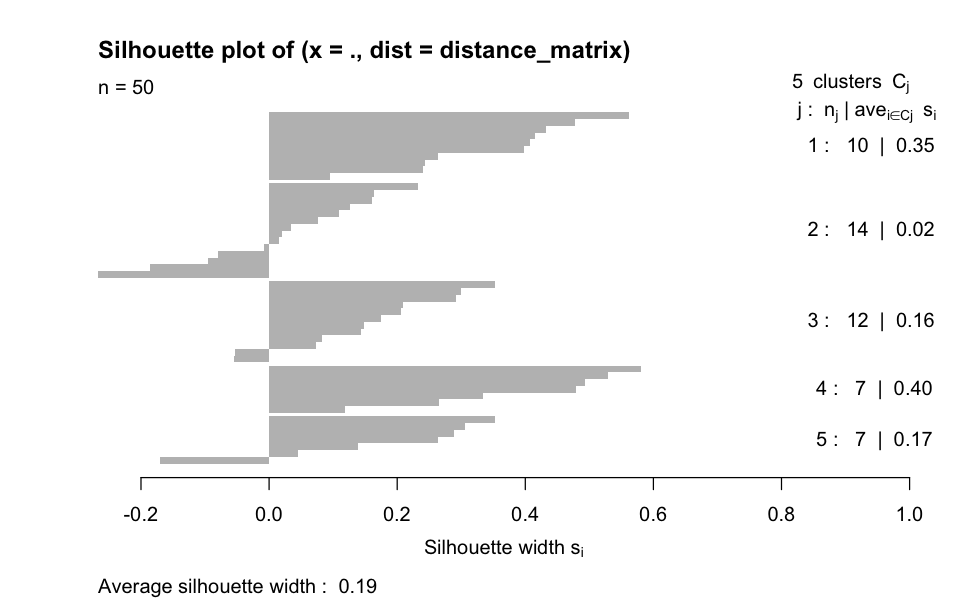

In [160]:
# For hierarchical cluster analysis
hierarchical_cluster %>% 
  cutree(k=5) %>% 
  silhouette(distance_matrix) %>% 
  plot

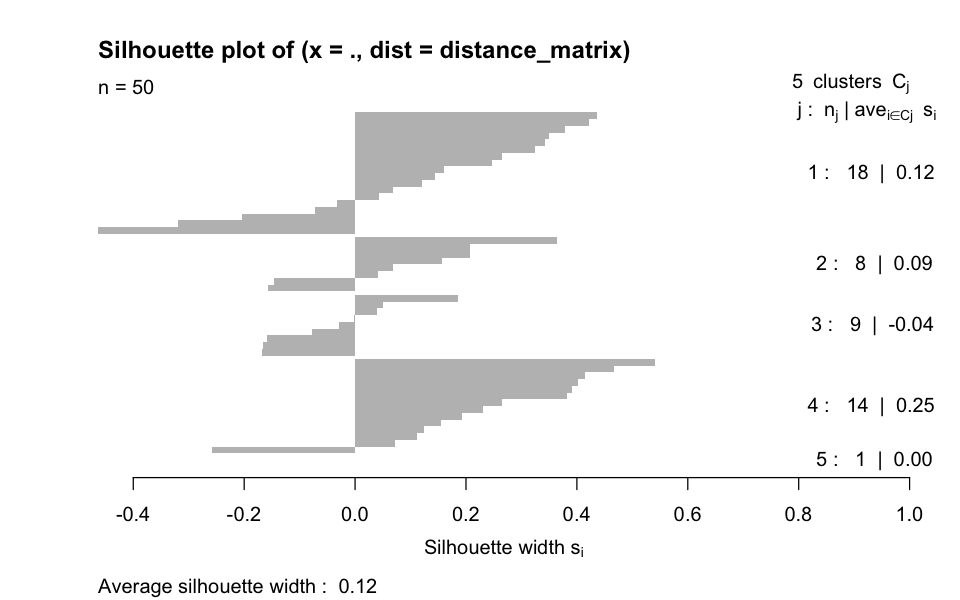

In [156]:
# For k-means cluster analysis
kmeans_cluster$cluster %>%
  silhouette(distance_matrix) %>%
  plot

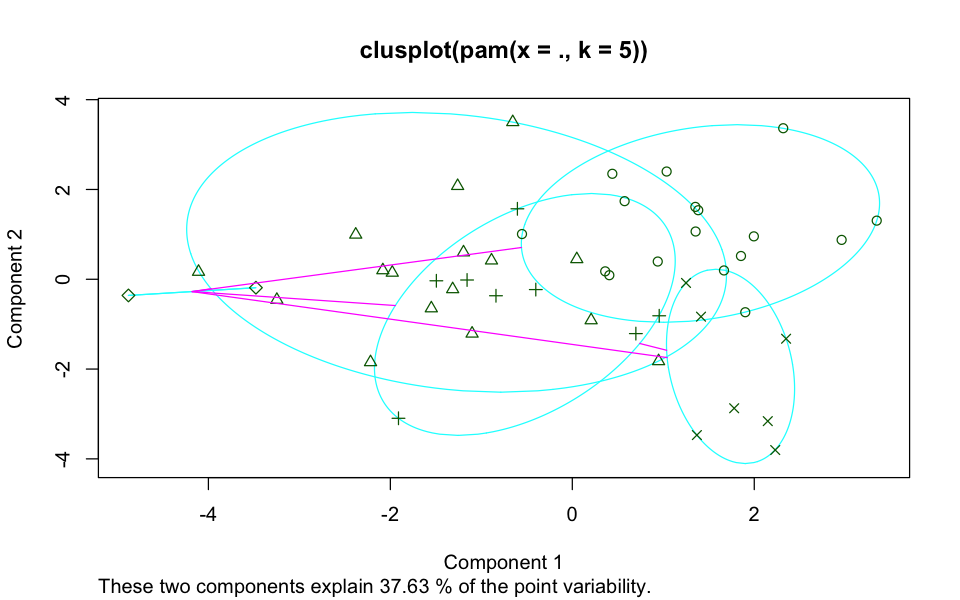

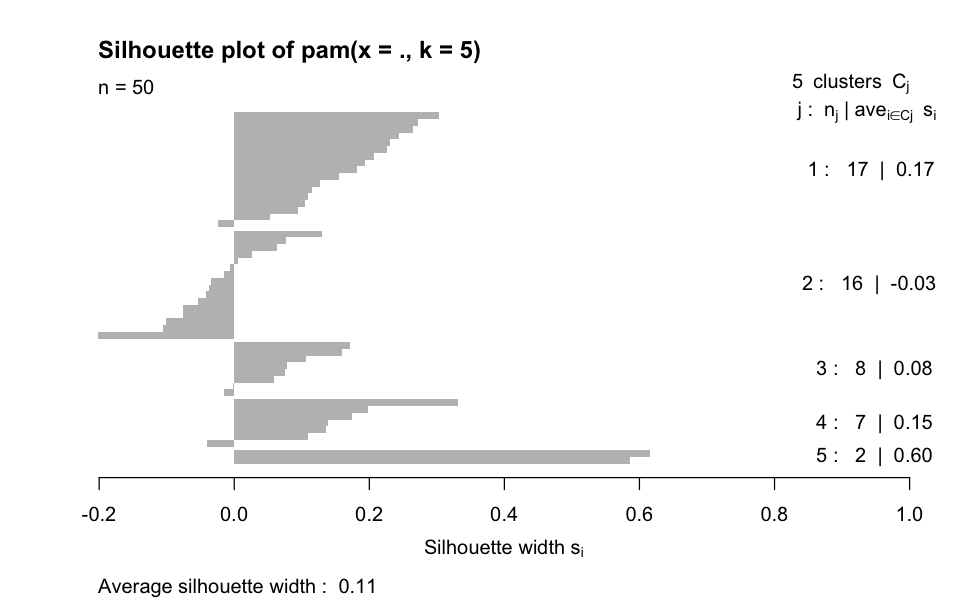

In [164]:
# For k-medoids
kmedoids_cluster %>%
  plot